# Recidivism in Broward County, a Classification Study





In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import datetime as dt

np.random.seed(42)


# Data Cleaning/EDA


To begin, extraneous data is removed from the dataset. All features here are either:
- name
- dates not relevant to analysis (i.e. screening date)
- case numbers/id codes
- recidivism specific markers (i.e. r_charge_degree is a prisoner's crime when they recidiviate)

In [528]:
#upload data, drop columns, and prep some data for joining

df = pd.read_csv("https://raw.githubusercontent.com/maxwellhouse34/MetisClassification/e5899f189c76e1fcf05f6fa7a2d8287feb8213af/compas-scores-two-years.csv", 
                 parse_dates = ["dob", "c_jail_in", "c_jail_out", "c_offense_date", "c_arrest_date"])
df.drop([#id/Compas specific values not useful
         "name", 
         "compas_screening_date",
         "days_b_screening_arrest",
         "age_cat", #age available as continuous variable
         "c_case_number", 
         "c_days_from_compas", 
         "screening_date",
         'decile_score.1',
         #post recidivism features; not useful in prediction
         "r_case_number", 
         "r_charge_degree", 
         'r_days_from_arrest',
         'r_offense_date', 
         'r_jail_in', 
         'r_jail_out',
         'vr_offense_date', 
         "v_screening_date", 
         "v_type_of_assessment", 
         "vr_case_number", 
         "vr_charge_degree",
         "score_text",
         "v_score_text",
         "violent_recid",
         "priors_count.1",
         "start",
         "end",
         "in_custody",
         "out_custody",
         "event",
         "r_charge_desc",
         "v_decile_score",
         "vr_charge_desc",
         "type_of_assessment"], axis = 1, inplace = True)
df["first"] = df["first"].str.lower()
df["last"] = df["last"].str.lower()

df["sex"] = (df["sex"] == "Male").astype("int")





Remaining Features (more will be removed as they are not needed for analysis)
- first: first name
- last: last name
- sex: 1 for male, 0 for female
- race: race, one of 6
- juv_fel_count: how many felonies as a juvenile
- decile_score: compas score
- juv_misd_count: how many misdemeanors as juvenile
- priors_counts: proior adult offenses
- c_jail_in/out: initial crime start and end dates
- c_offense_date: when did offense happen
- c_arrest date: when arrested
- c_charge_degree: felony, misdemeanor, or other
- c_charge_desc: description of charge
- is_recid: marker for recidivism
- is_violent_recid: marker for violent recidivism
- two_year_recid: marker for recidivism in two years


To identify the length of stay, I subtracted the start from the end date and converted the difference into days. I also created a marker for if the prisoner did not enter jail, for prisoners who's crimes did not lead to jailtime or were released with time served.

In [529]:
df["stay_length_day"] = (df["c_jail_out"]- df["c_jail_in"]).dt.days +1
df["entered_jail"] = (~df["stay_length_day"].isna()).astype("int")
df["stay_length_day"].fillna(0, inplace = True)
df["stay_length_day"] = df["stay_length_day"].astype("int")



There are hundreds of specific charges, so I wanted to narrow the categories down to specific types. To do so, I created word stems that occured in the most common sentences, and searched each sentence for any of those key words. Fortunately, not many of the sentences had multiple key words (i.e. Vehicular Manslaughter was not in the list). To account for those that do, I created a higher priority dictionary that comes first to filter those values (Manslaughter instead of Vehicluar, as I would want that crime classified within Murder/Manslaughter)

In [530]:
def sentence_type_processor (sentence):
    if pd.isna(sentence):
        return sentence
    sentence = sentence.lower()
    descriptor_crime_dict = {"dom":"Domestic Abuse",
                             "repeat viol":"Domestic Abuse",
                             "child" : "Child",
                             "rape": "Sexual",
                             "exposure": "Sexual",
                             "prostit": "Sexual",
                             "molest" : "Sexual",
                             "sex": "Sexual",
                             "solicitation": "Sexual",
                             "arson": "Arson",
                             "shoot": "Firearm",
                             "murder":"Murder",
                             "manslaughter": "Murder"                     
    }


    crime_dict = {"no charge" : "No Charge",
                 "dui":"Driving",
                 "driv": "Driving",
                 "license" : "Driving",
                 "fleeing": "Driving",
                 "veh": "Driving",
                 "accident" : "Driving",
                 "lictag" : "Driving",
                 "dl" : "Driving",
                 "cocaine": "Drugs",
                 "meth": "Drugs",
                 "contraband" : "Drugs",
                 "cannabis": "Drugs",
                 "drugs": "Drugs",
                 "poss" : "Drugs",
                 "traffick": "Drugs",
                 "kidnapping":"Kidnapping/Stalking",
                 "imprisonment" : "Kidnapping/Stalking",
                 "stalking" : "Kidnapping/Stalking",
                 "theft" : "Theft",
                 "burg": "Theft",
                 "stolen": "Theft",
                 "larceny": "Theft",
                 "robber": "Theft",
                 "embezzlement": "Theft",
                 "ownership" : "Theft",
                 "fraud": "Theft",
                 "corrupt": "Theft",
                 "false" : "Theft",
                 "forg":"Theft",
                 "tres": "Theft",
                 "personal id": "Theft",
                 "shoplifting": "Theft",
                 "assault": "Assault/Battery",
                 "batt": "Assault/Battery",
                 "mischief": "Mischief",
                 "damage": "Assualt/Battery",
                 "negligence": "Assault/Battery",
                 "firearm": "Firearm",
                 "tamper": "Interference",
                 "resist": "Interference",
                 "obey" : "Interference",
                 "obstruct": "Interference",
                 "disorderly": "Disorder",
                 "loitering": "Disorder"}
    for keyword in descriptor_crime_dict.keys():
        if sentence.find(keyword) >= 0:
                return descriptor_crime_dict[keyword]
    for keyword in crime_dict.keys():   
        if sentence.find(keyword) >= 0:
                return crime_dict[keyword]
    return "Other"

df["charge_category"] = df["c_charge_desc"].apply(sentence_type_processor)


Final cleanup before analysis. 
- Include a felony marker
- Drop identifying data, features that I have processed already, and extra features that didn't apply
- Drop missing values (only a few prisoners) to allow for logisitic regression



In [531]:
#create felony marker
df["felony"] = (df["c_charge_degree"] == "F").astype("int")

# drop unecessary data
df.drop(["id",
         "dob",
         "first", 
         "last",
         "c_charge_desc",
         "c_jail_in",
         "c_jail_out", 
         "c_offense_date", 
         "c_arrest_date",
         "c_charge_degree"], axis= 1, inplace = True)

#drop missing charge data
df.fillna("Other", inplace = True)

## EDA

In [532]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   sex               7214 non-null   int64 
 1   age               7214 non-null   int64 
 2   race              7214 non-null   object
 3   juv_fel_count     7214 non-null   int64 
 4   decile_score      7214 non-null   int64 
 5   juv_misd_count    7214 non-null   int64 
 6   juv_other_count   7214 non-null   int64 
 7   priors_count      7214 non-null   int64 
 8   is_recid          7214 non-null   int64 
 9   is_violent_recid  7214 non-null   int64 
 10  two_year_recid    7214 non-null   int64 
 11  stay_length_day   7214 non-null   int64 
 12  entered_jail      7214 non-null   int64 
 13  charge_category   7214 non-null   object
 14  felony            7214 non-null   int64 
dtypes: int64(13), object(2)
memory usage: 845.5+ KB


In [533]:
df.describe()

,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,two_year_recid,stay_length_day,entered_jail,felony
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,0.806626,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,0.481148,0.113529,0.450652,18.416828,0.957444,0.646798
std,0.394971,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,0.499679,0.317261,0.497593,50.140647,0.201868,0.477998
min,0.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000
75%,1.000000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,1.000000,0.000000,1.000000,9.000000,1.000000,1.000000
max,1.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1.000000,1.000000,1.000000,800.000000,1.000000,1.000000


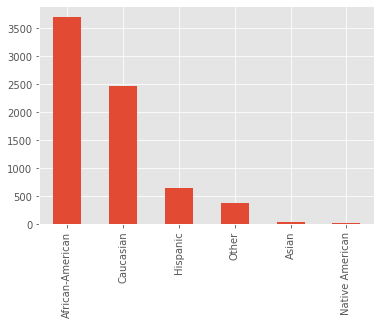

In [534]:
df.race.value_counts().plot(kind="bar")

### Noticings

- Target variable: 45% recidivism within two years
- 80% male
- average age is 34, median age is 31, result of outlier ages.
- most do not have juvenile records
- 3 priors on average, 2 priors is median, indicating outlier priors (people with lots of priors bring average up)
- 4% have no jail sentence
- Average stay is 18 days, but over half stay under 2 days
- Over 50% Black
- Assault, Driving, Drug, Theft based crime is vast majority of arrests
- Significant number (16%) held without being charged


In [535]:
# sns.heatmap(df.corr())
df.corr()

,sex,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,two_year_recid,stay_length_day,entered_jail,felony
sex,1.000000,-0.003215,0.055385,0.057860,0.047637,0.056384,0.119556,0.099190,0.059051,0.092169,0.056609,0.013274,0.053814
age,-0.003215,1.000000,-0.066003,-0.387733,-0.116833,-0.155286,0.142773,-0.197393,-0.097033,-0.190323,0.013980,-0.063651,-0.085623
juv_fel_count,0.055385,-0.066003,1.000000,0.177758,0.089153,0.047210,0.178519,0.094038,0.055261,0.092546,0.062571,0.011070,0.046081
decile_score,0.057860,-0.387733,0.177758,1.000000,0.215927,0.183463,0.435350,0.352337,0.171292,0.350703,0.208530,-0.000376,0.182201
juv_misd_count,0.047637,-0.116833,0.089153,0.215927,1.000000,0.272421,0.243671,0.111709,0.089628,0.109310,0.045179,0.004128,0.032098
juv_other_count,0.056384,-0.155286,0.047210,0.183463,0.272421,1.000000,0.103611,0.109179,0.053514,0.108004,0.042447,-0.003318,0.034508
priors_count,0.119556,0.142773,0.178519,0.435350,0.243671,0.103611,1.000000,0.277780,0.091209,0.275117,0.196339,0.021525,0.143621
is_recid,0.099190,-0.197393,0.094038,0.352337,0.111709,0.109179,0.277780,1.000000,0.371624,0.940544,0.124024,0.116432,0.100978
is_violent_recid,0.059051,-0.097033,0.055261,0.171292,0.089628,0.053514,0.091209,0.371624,1.000000,0.356476,0.077379,0.040812,-0.013464
two_year_recid,0.092169,-0.190323,0.092546,0.350703,0.109310,0.108004,0.275117,0.940544,0.356476,1.000000,0.124681,0.115040,0.104488


Before modeling, create dummy variables for categorical features. If I were creating a data pipeline and putting this algorithm into production, I would be using OHE. However, since my model is contained to this data set, I'm shortcutting with get_dummies.

In [536]:
df = pd.get_dummies(df)
df.drop(["race_Other", "charge_category_Arson"], axis=1, inplace = True)

In [537]:
df.columns

Index(['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'is_recid', 'is_violent_recid',
       'two_year_recid', 'stay_length_day', 'entered_jail', 'felony',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American',
       'charge_category_Assault/Battery', 'charge_category_Child',
       'charge_category_Disorder', 'charge_category_Domestic Abuse',
       'charge_category_Driving', 'charge_category_Drugs',
       'charge_category_Firearm', 'charge_category_Interference',
       'charge_category_Kidnapping/Stalking', 'charge_category_Mischief',
       'charge_category_Murder', 'charge_category_No Charge',
       'charge_category_Other', 'charge_category_Sexual',
       'charge_category_Theft'],
      dtype='object')

In [538]:
# sns.pairplot(df, hue = "two_year_recid")

### Patterns:
- Female recidivism is lower
- Younger criminals have higher recidivism rates
    - May be connected to crime more directly
    - Long second sentence or other adverse life experience may prevent older criminals from returning to prison. 
- Middle Aged White/Non-Black Males have lower recidivism rates
- Drug Charges had the greatest likelihood of recidivism



## Feature Engineering
Several patterns deserve further analysis in feature engineering (the visualizations for this process have been created in tableau and will be included in the final presentation):
- Stay_v_age: The difference in stay length for older prisoners who have/have not gone back to jail is much higher than the dfference for young prisoners. This feature increases the focus on older prisoners with longer stays.
- priors_v_age: a similar relationship with the number of priors, i.e. the older a prisoner gets, the more significant a difference in prior counts between people who did or did not recidivate.
- Young_AA: Young african americans were far more like to recidivate compared to other racial groups and age groups.


In [539]:
df["stay_v_age"] = df["stay_length_day"]*df["age"]

df["priors_v_age"] = df["priors_count"]*df["age"]

df["Young_AA"] = df['race_African-American'] * (df["age"]<30)

# df["age^2"] = df["age"]**2

# df["priors^2"] = df["priors_count"]**2





# Modeling

## Splitting

In [540]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, SCORERS
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, log_loss
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from lightgbm import LGBMClassifier
import lightgbm as lgb

#to check for different target variables, swap out test_for from testable list
test_for = "two_year_recid"
testable = ["is_recid", "is_violent_recid", "two_year_recid", "decile_score"]

#pull and split up data for initial analysis
X = df.drop(testable, axis = 1)
y = df[test_for]

#split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

#scaled features to determine weights
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [541]:
#add scoring model for quick and easy analysis
def score_this_model(model, loc_X = X_test_scaled, loc_y = y_test, is_tree = False):
    # if is_tree:
    #     results = model.predict(loc_X)
    # else:
    #     
    results = model.predict(loc_X)
    print("accuracy: {:6.4f}".format(accuracy_score(loc_y, results)))    
    print("precision: {:6.4f}".format(precision_score(loc_y, results)))
    print("recall: {:6.4f}".format(recall_score(loc_y, results)))
    print("roc_auc_score: {:6.4f}".format(roc_auc_score(loc_y, results)))
    print("f1_score: {:6.4f}".format(f1_score(loc_y, results)))
    print("log_loss: {:6.4f}".format(log_loss(loc_y, model.predict_proba(loc_X))))
    print(confusion_matrix(loc_y, results))

## Logistic Regression

An intital test for binary classification ultimately becomes the best model.

In [542]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)
score_this_model(log)



accuracy: 0.6937
precision: 0.6672
recall: 0.6107
roc_auc_score: 0.6850
f1_score: 0.6377
log_loss: 0.5977
[[612 194]
 [248 389]]


A simple model produces promising results - an accuracy that is sufficient for industry standards, and quickly. Let's see if any optimization can be done, especially if we focus on the f1-score to score the model, to balance percision and recall.

In [543]:
log_params = {'C' : np.logspace(-4, 4, 20),
            "penalty" : ["l2", "none"]} 

log = LogisticRegression()
grid_log = GridSearchCV(log, param_grid = log_params, cv = 5, scoring="accuracy", n_jobs = -1)
grid_log.fit(X_train_scaled, y_train)

print("Best params: ", grid_log.best_params_)
print("Best estimator: ", grid_log.best_estimator_)
print("Best score: ", grid_log.best_score_)
best_model = grid_log.best_estimator_


Best params:  {'C': 1.623776739188721, 'penalty': 'l2'}
Best estimator:  LogisticRegression(C=1.623776739188721)
Best score:  0.6752708066052954


Our optimized model has a slight drop in accuracy, but for a much better balance between precision and recall.

In [544]:
score_this_model(grid_log.best_estimator_)

accuracy: 0.6937
precision: 0.6672
recall: 0.6107
roc_auc_score: 0.6850
f1_score: 0.6377
log_loss: 0.5977
[[612 194]
 [248 389]]


The following features play a significant role in the probability of a prisoner recidivating. We see 3 underlying factors here: 
- The prior crime count of a prisoner is a strong positive factor.
- A prisoner entering/staying in jail is more likely to recidivate
- The older a prisoner is, the less likely they are to recidivate, unless they are black.

In [545]:
coefs = pd.Series(grid_log.best_estimator_.coef_[0], X.columns).sort_values()
log_coefs = pd.DataFrame(coefs[coefs.abs()>.10], columns = ["weight"])
log_coefs

,weight
priors_v_age,-0.406482
age,-0.356129
juv_other_count,0.102592
charge_category_Assault/Battery,0.104391
sex,0.104708
stay_length_day,0.113284
juv_fel_count,0.127097
charge_category_Theft,0.160741
Young_AA,0.181097
charge_category_Drugs,0.194614


## XGBoost
I wanted to compare the relatively simple logistic regression with a more powerful classification model, to see what else was possible.

In [546]:
gbm = xgb.XGBClassifier()
gbm.fit(X_train, y_train)
score_this_model(gbm, loc_X = X_test, is_tree = True)

accuracy: 0.7041
precision: 0.6733
recall: 0.6405
roc_auc_score: 0.6974
f1_score: 0.6565
log_loss: 0.5779
[[608 198]
 [229 408]]


So without any optimization, XGBoost is already close to logistic regression in accuracy. Let's optimize the function to see what we can improve. XGBoost is slow, so I'm using RandomizeSearchCV to standardize the timing.

In [547]:
xgbc = xgb.XGBClassifier(objective= 'binary:logistic',
                         nthread=4)

params = {
    'max_depth': range (2, 11, 1),
    'n_estimators': range(50, 261, 20),
    'learning_rate': np.logspace(-0.5,-2, 5)
}



grid_xgb = RandomizedSearchCV(xgbc,
                              param_distributions=params,
                              n_iter = 20, 
                              scoring = "accuracy",
                              n_jobs = -1,
                              cv = 5,
                              verbose=True)

grid_xgb.fit(X_train, y_train)

print("Best params: ", grid_xgb.best_params_)
print("Best estimator: ", grid_xgb.best_estimator_)
print("Best score: ", grid_xgb.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params:  {'n_estimators': 90, 'max_depth': 2, 'learning_rate': 0.1333521432163324}
Best estimator:  XGBClassifier(learning_rate=0.1333521432163324, max_depth=2, n_estimators=90,
              nthread=4)
Best score:  0.6905192554412658


Tuning variables did not produce tremendous success, but the initial model was still strong enough to feel confident in. An examination of feature weights shows that the breakdown is similar to logisitc regresion, but slightly more nuanced, including a focus on certain charge types, sex, and race.

In [548]:
gbm_coefs = pd.Series(gbm.feature_importances_, X.columns).sort_values(ascending = False)
gbm_coefs[gbm_coefs>.03]

priors_count                 0.216991
entered_jail                 0.113548
age                          0.084678
charge_category_Other        0.051206
Young_AA                     0.045154
sex                          0.038696
charge_category_Drugs        0.038176
juv_other_count              0.037896
stay_length_day              0.035382
charge_category_No Charge    0.031391
dtype: float32

In [549]:
#Install What-If Tool Widget and SHAP library
!pip install --upgrade --quiet witwidget shap

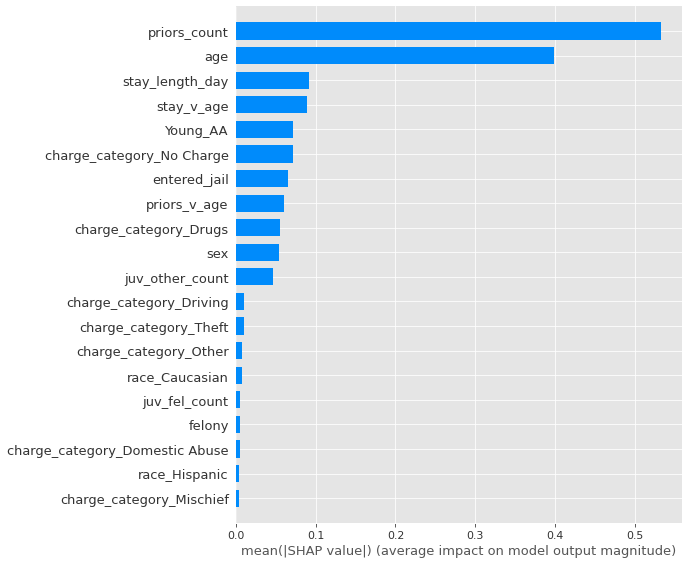

In [550]:
import shap
shap_values = shap.TreeExplainer(gbm).shap_values(X)
shap.summary_plot(shap_values, X, plot_type = "bar",)

## Model Performance by Race

To further control for race, filtered data sets for black and white defendants, to see the effectiveness of each predictive model.
These results won't be entirely accurate, as there is some leakage of the train data that is somewhat unavoidable, but they really function comparitavely

In [551]:
white_X = X[X["race_Caucasian"]== 1]
white_y = y[X["race_Caucasian"]== 1]

black_X = X[X["race_African-American"]== 1]
black_y = y[X["race_African-American"]== 1]

X_scaled_white = scaler.transform(white_X)
X_scaled_black = scaler.transform(black_X)



Interestingly, recall is much lower for white prisoners, indicating that the model frequently misses white prisoners who recidivate.

In [552]:
print("white prisoners")
print("")
score_this_model(best_model, X_scaled_white, white_y)
print("")
print("black prisoners")
print("")
score_this_model(best_model, X_scaled_black, black_y)

white prisoners

accuracy: 0.6801
precision: 0.6496
recall: 0.4068
roc_auc_score: 0.6322
f1_score: 0.5003
log_loss: 0.6005
[[1276  212]
 [ 573  393]]

black prisoners

accuracy: 0.6834
precision: 0.6885
recall: 0.7023
roc_auc_score: 0.6829
f1_score: 0.6953
log_loss: 0.6035
[[1191  604]
 [ 566 1335]]


## Visualizations


Here is a final visualization of the logistic regression model's confusion matrix, which helps give a clearer picture of how successful the algorithm is.

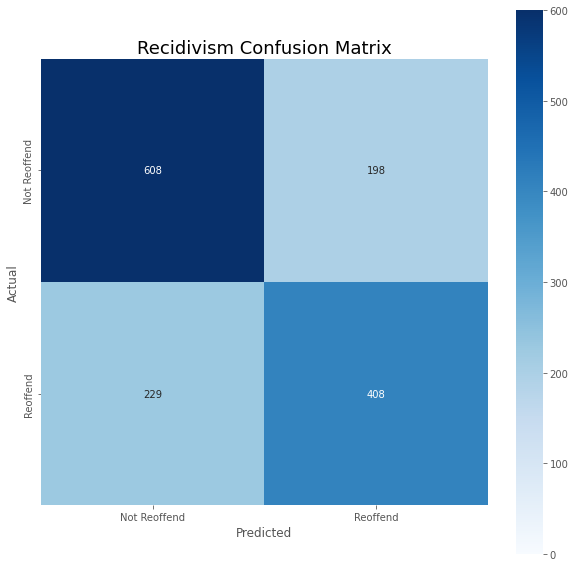

In [553]:
plt.style.use('ggplot')
confusion = confusion_matrix(y_test, gbm.predict(X_test))
plt.figure(figsize=(10,10))
sns.heatmap(confusion,
            cmap = 'Blues',
            annot=True,
            square=True,
            xticklabels = ["Not Reoffend", "Reoffend"],
            yticklabels = ["Not Reoffend", "Reoffend"],
            fmt = "g",
            norm = matplotlib.colors.Normalize(vmin=0, vmax=600))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Recidivism Confusion Matrix', fontdict={'fontsize':18});


Here is a chart of relative feature weights from that algorithm, which allow us to examine the role that different factors play in the judicial system and sentencing.

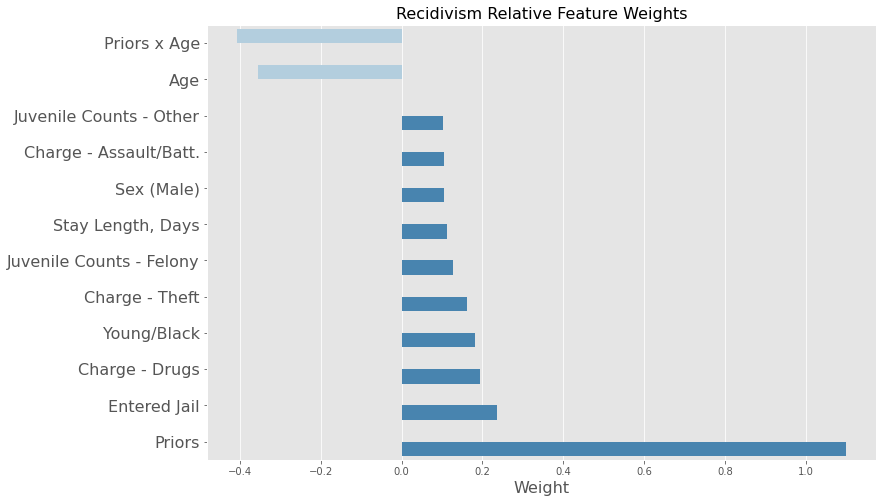

In [554]:
labels = ["Priors x Age", 
          "Age", 
          "Juvenile Counts - Other", 
          "Charge - Assault/Batt.",
          "Sex (Male)",
          "Stay Length, Days",
          "Juvenile Counts - Felony",
          "Charge - Theft",
          "Young/Black",
          "Charge - Drugs",
          "Entered Jail",
          "Priors"]

plt.style.use('ggplot')
plt.figure(figsize=(12,8))

sns.barplot(x= log_coefs["weight"], 
            y = labels, 
            hue = log_coefs["weight"]>0,
            orient = "h",  
            palette="Blues")

plt.xlabel("Weight", fontdict={'fontsize':16})
plt.yticks(fontsize = 16)
plt.title('Recidivism Relative Feature Weights', fontdict={'fontsize':16})
plt.legend([],[], frameon=False)